  8%|▊         | 12/150 [00:00<00:01, 114.36it/s]

[case 0] ber: 0.072265625, ref_ber: 0.287109375
[case 1] ber: 0.162109375, ref_ber: 0.48046875
[case 2] ber: 0.265625, ref_ber: 0.4830729166666667
[case 3] ber: 0.134765625, ref_ber: 0.224609375
[case 4] ber: 0.3307291666666667, ref_ber: 0.4427083333333333
[case 5] ber: 0.3020833333333333, ref_ber: 0.3854166666666667
[case 6] ber: 0.3359375, ref_ber: 0.443359375
[case 7] ber: 0.17578125, ref_ber: 0.40234375
[case 8] ber: 0.20703125, ref_ber: 0.296875
[case 9] ber: 0.11328125, ref_ber: 0.439453125
[case 10] ber: 0.380859375, ref_ber: 0.521484375
[case 11] ber: 0.3251953125, ref_ber: 0.466796875
[case 12] ber: 0.2903645833333333, ref_ber: 0.4596354166666667
[case 13] ber: 0.20963541666666666, ref_ber: 0.3294270833333333
[case 14] ber: 0.3486328125, ref_ber: 0.470703125
[case 15] ber: 0.3408203125, ref_ber: 0.4072265625
[case 16] ber: 0.2734375, ref_ber: 0.3723958333333333
[case 17] ber: 0.294921875, ref_ber: 0.455078125
[case 18] ber: 0.17578125, ref_ber: 0.4375
[case 19] ber: 0.29947916

 27%|██▋       | 40/150 [00:00<00:00, 130.13it/s]

[case 24] ber: 0.26953125, ref_ber: 0.4088541666666667
[case 25] ber: 0.2864583333333333, ref_ber: 0.4348958333333333
[case 26] ber: 0.2109375, ref_ber: 0.4401041666666667
[case 27] ber: 0.1875, ref_ber: 0.466796875
[case 28] ber: 0.16796875, ref_ber: 0.466796875
[case 29] ber: 0.189453125, ref_ber: 0.40234375
[case 30] ber: 0.2630208333333333, ref_ber: 0.4361979166666667
[case 31] ber: 0.3203125, ref_ber: 0.453125
[case 32] ber: 0.1640625, ref_ber: 0.4140625
[case 33] ber: 0.18359375, ref_ber: 0.40234375
[case 34] ber: 0.09375, ref_ber: 0.3671875
[case 35] ber: 0.19140625, ref_ber: 0.45703125
[case 36] ber: 0.27734375, ref_ber: 0.4856770833333333
[case 37] ber: 0.173828125, ref_ber: 0.296875
[case 38] ber: 0.23177083333333334, ref_ber: 0.4114583333333333
[case 39] ber: 0.18359375, ref_ber: 0.3984375
[case 40] ber: 0.2630208333333333, ref_ber: 0.30859375
[case 41] ber: 0.23958333333333334, ref_ber: 0.4010416666666667
[case 42] ber: 0.11328125, ref_ber: 0.28125
[case 43] ber: 0.22851562

 46%|████▌     | 69/150 [00:00<00:00, 130.30it/s]

[case 51] ber: 0.23828125, ref_ber: 0.3841145833333333
[case 52] ber: 0.1796875, ref_ber: 0.41796875
[case 53] ber: 0.2708333333333333, ref_ber: 0.5104166666666666
[case 54] ber: 0.3876953125, ref_ber: 0.4765625
[case 55] ber: 0.31640625, ref_ber: 0.4228515625
[case 56] ber: 0.2916666666666667, ref_ber: 0.484375
[case 57] ber: 0.193359375, ref_ber: 0.44140625
[case 58] ber: 0.2864583333333333, ref_ber: 0.4947916666666667
[case 59] ber: 0.3072916666666667, ref_ber: 0.4921875
[case 60] ber: 0.16015625, ref_ber: 0.42578125
[case 61] ber: 0.34375, ref_ber: 0.474609375
[case 62] ber: 0.1640625, ref_ber: 0.4140625
[case 63] ber: 0.1484375, ref_ber: 0.36328125
[case 64] ber: 0.16796875, ref_ber: 0.3125
[case 65] ber: 0.1484375, ref_ber: 0.302734375
[case 66] ber: 0.15234375, ref_ber: 0.44140625
[case 67] ber: 0.150390625, ref_ber: 0.453125
[case 68] ber: 0.173828125, ref_ber: 0.4453125
[case 69] ber: 0.2864583333333333, ref_ber: 0.453125
[case 70] ber: 0.28125, ref_ber: 0.4205729166666667
[ca

 67%|██████▋   | 100/150 [00:00<00:00, 140.29it/s]

[case 79] ber: 0.3203125, ref_ber: 0.4765625
[case 80] ber: 0.2421875, ref_ber: 0.4479166666666667
[case 81] ber: 0.17578125, ref_ber: 0.4375
[case 82] ber: 0.203125, ref_ber: 0.39453125
[case 83] ber: 0.2760416666666667, ref_ber: 0.4348958333333333
[case 84] ber: 0.1796875, ref_ber: 0.46875
[case 85] ber: 0.185546875, ref_ber: 0.46484375
[case 86] ber: 0.189453125, ref_ber: 0.455078125
[case 87] ber: 0.1015625, ref_ber: 0.29296875
[case 88] ber: 0.2643229166666667, ref_ber: 0.47265625
[case 89] ber: 0.23177083333333334, ref_ber: 0.359375
[case 90] ber: 0.24479166666666666, ref_ber: 0.390625
[case 91] ber: 0.3388671875, ref_ber: 0.330078125
[case 92] ber: 0.15234375, ref_ber: 0.392578125
[case 93] ber: 0.146484375, ref_ber: 0.419921875
[case 94] ber: 0.10546875, ref_ber: 0.41015625
[case 95] ber: 0.328125, ref_ber: 0.478515625
[case 96] ber: 0.15625, ref_ber: 0.45703125
[case 97] ber: 0.3125, ref_ber: 0.4270833333333333
[case 98] ber: 0.357421875, ref_ber: 0.48046875
[case 99] ber: 0.3

 87%|████████▋ | 130/150 [00:00<00:00, 141.66it/s]

[case 110] ber: 0.3134765625, ref_ber: 0.4306640625
[case 111] ber: 0.1015625, ref_ber: 0.359375
[case 112] ber: 0.1484375, ref_ber: 0.38671875
[case 113] ber: 0.1171875, ref_ber: 0.25390625
[case 114] ber: 0.2838541666666667, ref_ber: 0.5013020833333334
[case 115] ber: 0.28125, ref_ber: 0.3984375
[case 116] ber: 0.193359375, ref_ber: 0.48046875
[case 117] ber: 0.2890625, ref_ber: 0.4557291666666667
[case 118] ber: 0.1640625, ref_ber: 0.28125
[case 119] ber: 0.23307291666666666, ref_ber: 0.4075520833333333
[case 120] ber: 0.14453125, ref_ber: 0.19140625
[case 121] ber: 0.2760416666666667, ref_ber: 0.4674479166666667
[case 122] ber: 0.1796875, ref_ber: 0.203125
[case 123] ber: 0.30859375, ref_ber: 0.416015625
[case 124] ber: 0.2864583333333333, ref_ber: 0.4674479166666667
[case 125] ber: 0.26171875, ref_ber: 0.4192708333333333
[case 126] ber: 0.34375, ref_ber: 0.4895833333333333
[case 127] ber: 0.291015625, ref_ber: 0.458984375
[case 128] ber: 0.3134765625, ref_ber: 0.4404296875
[case 1

100%|██████████| 150/150 [00:01<00:00, 137.30it/s]


[case 140] ber: 0.2916666666666667, ref_ber: 0.4440104166666667
[case 141] ber: 0.203125, ref_ber: 0.41015625
[case 142] ber: 0.2578125, ref_ber: 0.3359375
[case 143] ber: 0.19140625, ref_ber: 0.474609375
[case 144] ber: 0.1328125, ref_ber: 0.30859375
[case 145] ber: 0.30078125, ref_ber: 0.44140625
[case 146] ber: 0.22395833333333334, ref_ber: 0.3645833333333333
[case 147] ber: 0.2526041666666667, ref_ber: 0.4739583333333333
[case 148] ber: 0.119140625, ref_ber: 0.44921875
[case 149] ber: 0.15234375, ref_ber: 0.416015625


 10%|█         | 15/150 [00:00<00:00, 145.91it/s]

[case 0] ber: 0.185546875, ref_ber: 0.287109375
[case 1] ber: 0.380859375, ref_ber: 0.48046875
[case 2] ber: 0.7194010416666667, ref_ber: 0.4830729166666667
[case 3] ber: 0.9088541666666667, ref_ber: 0.224609375
[case 4] ber: 1.2473958333333335, ref_ber: 0.4427083333333333
[case 5] ber: 1.5963541666666667, ref_ber: 0.3854166666666667
[case 6] ber: 1.9596354166666667, ref_ber: 0.443359375
[case 7] ber: 2.197916666666667, ref_ber: 0.40234375
[case 8] ber: 2.440104166666667, ref_ber: 0.296875
[case 9] ber: 2.615885416666667, ref_ber: 0.439453125
[case 10] ber: 2.985026041666667, ref_ber: 0.521484375
[case 11] ber: 3.346354166666667, ref_ber: 0.466796875
[case 12] ber: 3.6536458333333335, ref_ber: 0.4596354166666667
[case 13] ber: 3.928385416666667, ref_ber: 0.3294270833333333
[case 14] ber: 4.321940104166667, ref_ber: 0.470703125
[case 15] ber: 4.694986979166667, ref_ber: 0.4072265625
[case 16] ber: 5.025716145833334, ref_ber: 0.3723958333333333
[case 17] ber: 5.371419270833334, ref_ber: 

 20%|██        | 30/150 [00:00<00:00, 145.85it/s]

[case 21] ber: 6.5224609375, ref_ber: 0.451171875
[case 22] ber: 6.8349609375, ref_ber: 0.4296875
[case 23] ber: 7.0419921875, ref_ber: 0.3359375
[case 24] ber: 7.340169270833333, ref_ber: 0.4088541666666667
[case 25] ber: 7.660481770833333, ref_ber: 0.4348958333333333
[case 26] ber: 7.978190104166666, ref_ber: 0.4401041666666667
[case 27] ber: 8.206705729166666, ref_ber: 0.466796875
[case 28] ber: 8.444986979166666, ref_ber: 0.466796875
[case 29] ber: 8.694986979166666, ref_ber: 0.40234375


 31%|███       | 46/150 [00:00<00:00, 149.63it/s]

[case 30] ber: 8.9853515625, ref_ber: 0.4361979166666667
[case 31] ber: 9.357421875, ref_ber: 0.453125
[case 32] ber: 9.599609375, ref_ber: 0.4140625
[case 33] ber: 9.841796875, ref_ber: 0.40234375
[case 34] ber: 10.052734375, ref_ber: 0.3671875
[case 35] ber: 10.267578125, ref_ber: 0.45703125
[case 36] ber: 10.590494791666666, ref_ber: 0.4856770833333333
[case 37] ber: 10.828776041666666, ref_ber: 0.296875
[case 38] ber: 11.081380208333332, ref_ber: 0.4114583333333333
[case 39] ber: 11.300130208333332, ref_ber: 0.3984375
[case 40] ber: 11.582682291666666, ref_ber: 0.30859375
[case 41] ber: 11.844401041666666, ref_ber: 0.4010416666666667
[case 42] ber: 12.051432291666666, ref_ber: 0.28125
[case 43] ber: 12.297526041666666, ref_ber: 0.458984375
[case 44] ber: 12.670572916666666, ref_ber: 0.4609375
[case 45] ber: 13.068033854166666, ref_ber: 0.4677734375
[case 46] ber: 13.306315104166666, ref_ber: 0.40234375
[case 47] ber: 13.666666666666666, ref_ber: 0.4609375
[case 48] ber: 14.03678385

 51%|█████▏    | 77/150 [00:00<00:00, 144.54it/s]

[case 59] ber: 17.609049479166664, ref_ber: 0.4921875
[case 60] ber: 17.810221354166664, ref_ber: 0.42578125
[case 61] ber: 18.153971354166664, ref_ber: 0.474609375
[case 62] ber: 18.361002604166664, ref_ber: 0.4140625
[case 63] ber: 18.532877604166664, ref_ber: 0.36328125
[case 64] ber: 18.745768229166664, ref_ber: 0.3125
[case 65] ber: 18.952799479166664, ref_ber: 0.302734375
[case 66] ber: 19.198893229166664, ref_ber: 0.44140625
[case 67] ber: 19.405924479166664, ref_ber: 0.453125
[case 68] ber: 19.618815104166664, ref_ber: 0.4453125
[case 69] ber: 19.939127604166664, ref_ber: 0.453125
[case 70] ber: 20.249023437499996, ref_ber: 0.4205729166666667
[case 71] ber: 20.565429687499996, ref_ber: 0.47265625
[case 72] ber: 20.885742187499996, ref_ber: 0.2708333333333333
[case 73] ber: 21.249023437499996, ref_ber: 0.3798828125
[case 74] ber: 21.657226562499996, ref_ber: 0.4140625
[case 75] ber: 21.881835937499996, ref_ber: 0.435546875
[case 76] ber: 22.102539062499996, ref_ber: 0.5
[case 77

 74%|███████▍  | 111/150 [00:00<00:00, 152.53it/s]

[case 92] ber: 26.50944010416666, ref_ber: 0.392578125
[case 93] ber: 26.69303385416666, ref_ber: 0.419921875
[case 94] ber: 26.88444010416666, ref_ber: 0.41015625
[case 95] ber: 27.23404947916666, ref_ber: 0.478515625
[case 96] ber: 27.41373697916666, ref_ber: 0.45703125
[case 97] ber: 27.747070312499993, ref_ber: 0.4270833333333333
[case 98] ber: 28.108398437499993, ref_ber: 0.48046875
[case 99] ber: 28.477539062499993, ref_ber: 0.521484375
[case 100] ber: 28.661132812499993, ref_ber: 0.34375
[case 101] ber: 28.97623697916666, ref_ber: 0.4375
[case 102] ber: 29.29134114583333, ref_ber: 0.4140625
[case 103] ber: 29.52571614583333, ref_ber: 0.5078125
[case 104] ber: 29.81087239583333, ref_ber: 0.3802083333333333
[case 105] ber: 30.12858072916666, ref_ber: 0.3932291666666667
[case 106] ber: 30.47037760416666, ref_ber: 0.400390625
[case 107] ber: 30.68131510416666, ref_ber: 0.4140625
[case 108] ber: 30.96516927083333, ref_ber: 0.3450520833333333
[case 109] ber: 31.295898437499996, ref_be

 97%|█████████▋| 145/150 [00:00<00:00, 159.46it/s]

[case 125] ber: 35.66276041666667, ref_ber: 0.4192708333333333
[case 126] ber: 36.03515625000001, ref_ber: 0.4895833333333333
[case 127] ber: 36.38671875000001, ref_ber: 0.458984375
[case 128] ber: 36.74707031250001, ref_ber: 0.4404296875
[case 129] ber: 36.91894531250001, ref_ber: 0.2578125
[case 130] ber: 37.19759114583334, ref_ber: 0.3359375
[case 131] ber: 37.56282552083334, ref_ber: 0.33984375
[case 132] ber: 37.88574218750001, ref_ber: 0.4375
[case 133] ber: 38.18782552083334, ref_ber: 0.2916666666666667
[case 134] ber: 38.49641927083334, ref_ber: 0.41015625
[case 135] ber: 38.81673177083334, ref_ber: 0.5234375
[case 136] ber: 39.05110677083334, ref_ber: 0.42578125
[case 137] ber: 39.39746093750001, ref_ber: 0.5208333333333334
[case 138] ber: 39.58496093750001, ref_ber: 0.1953125
[case 139] ber: 39.91048177083334, ref_ber: 0.390625
[case 140] ber: 40.24511718750001, ref_ber: 0.4440104166666667
[case 141] ber: 40.48730468750001, ref_ber: 0.41015625
[case 142] ber: 40.7945963541666

100%|██████████| 150/150 [00:00<00:00, 152.29it/s]

[case 149] ber: 42.43847656250001, ref_ber: 0.416015625


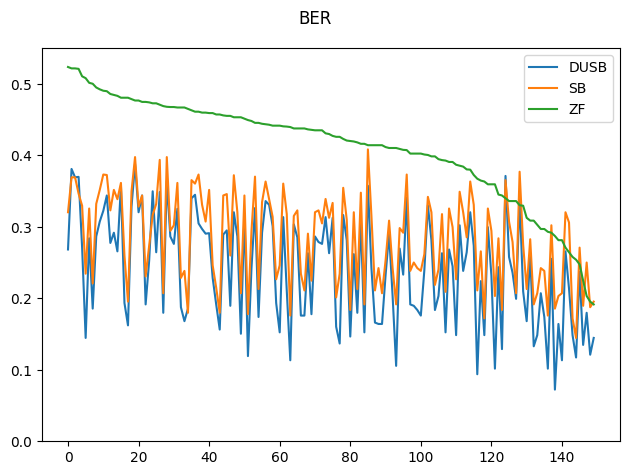

>> Method: DUSB
>> time cost: 1.09
>> avg. BER = 0.23971
>> Method: BSB
>> time cost: 0.99
>> avg. BER = 0.28292


In [5]:
import pickle
from time import time
from glob import glob
import os
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

def compute_ber(solution: ndarray, bits: ndarray) -> float:
    '''
    Compute BER for the solution from QAIAs.

    Firstly, both the solution from QAIAs and generated bits should be transformed into gray-coded,
    and then compute the ber.

    Reference
    ---------
    [1] Kim M, Venturelli D, Jamieson K. Leveraging quantum annealing for large MIMO processing in centralized radio access networks.
        Proceedings of the ACM special interest group on data communication. 2019: 241-255.\

    Input
    -----
    solution: [rb*2*Nt, ], np.int
        The binary array filled with ones and minus ones.

    bits: [Nt, nbps], np.int
        The binary array filled with ones and zeros.
    Ouput
    -----
    ber: np.float
        A scalar, the BER.
    '''
    solution = solution.astype(np.int32)
    bits = bits.astype(np.int32)

    # convert the bits from sionna style to constellation style
    # Sionna QAM16 map: https://nvlabs.github.io/sionna/examples/Hello_World.html
    '''
    [sionna-style]
        1011 1001 0001 0011
        1010 1000 0000 0010
        1110 1100 0100 0110
        1111 1101 0101 0111
    [constellation-style] i.e. the "gray code" in QuAMax paper
        0010 0110 1110 1010
        0011 0111 1111 1011
        0001 0101 1101 1001
        0000 0100 1100 1000
    '''
    bits_constellation = 1 - np.concatenate([bits[..., 0::2], bits[..., 1::2]], axis=-1)

    # Fig. 2 from arXiv:2001.04014, the QuAMax paper converting QuAMax to gray coded
    num_bits_per_symbol = bits_constellation.shape[1]
    rb = num_bits_per_symbol // 2
    bits_hat = solution.reshape(rb, 2, -1)  # [rb, c=2, Nt]
    bits_hat = np.concatenate([bits_hat[:, 0], bits_hat[:, 1]], axis=0)  # [2*rb, Nt]
    bits_hat = bits_hat.T.copy()  # [Nt, 2*rb]
    bits_hat[bits_hat == -1] = 0  # convert Ising {-1, 1} to QUBO {0, 1}
    # QuAMax => intermediate code
    '''
    [QuAMax-style]
        0011 0111 1011 1111
        0010 0110 1010 1110
        0001 0101 1001 1101
        0000 0100 1000 1100
    [intermediate-style]
        0011 0100 1011 1100
        0010 0101 1010 1101
        0001 0110 1001 1110
        0000 0111 1000 1111
    '''
    output_bit = bits_hat.copy()  # copy b[0]
    index = np.nonzero(bits_hat[:, rb - 1] == 1)[0]  # select even columns
    bits_hat[index, rb:] = 1 - bits_hat[index, rb:]  # invert bits of high part (flip upside-down)
    # Differential bit encoding, intermediate code => gray code (constellation-style)
    for i in range(1, num_bits_per_symbol):  # b[i] = b[i] ^ b[i-1]
        output_bit[:, i] = np.logical_xor(bits_hat[:, i], bits_hat[:, i - 1])
    # calc BER
    ber = np.mean(bits_constellation != output_bit)
    return ber


class Judger:

    def __init__(self, test_cases):
        self.test_cases = test_cases

    @staticmethod
    def infer(ising_generator, qaia_mld_solver, H, y, num_bits_per_symbol, snr):
        J, h = ising_generator(H, y, num_bits_per_symbol, snr)
        bits = qaia_mld_solver(J, h)
        return bits

    def benchmark(self, ising_gen, qaia_mld_solver):
        from collections import defaultdict
        ber_list = []
        ZF_ber_list = []
        avgber_per_Nt = defaultdict(list)
        avgber_per_snr = defaultdict(list)
        avgber_per_nbps = defaultdict(list)

        avgber = 0
        for i, case in enumerate(tqdm(self.test_cases)):
            H, y, bits_truth, num_bits_per_symbol, snr, ZF_ber = case
            bits_decode = self.infer(ising_gen, qaia_mld_solver, H, y, num_bits_per_symbol, snr)
            ber = compute_ber(bits_decode, bits_truth)
            avgber += ber
            print(f'[case {i}] ber: {ber}, ref_ber: {ZF_ber}')

            ber_list.append(ber)
            ZF_ber_list.append(ZF_ber)
            avgber_per_Nt[H.shape[1]].append(ber)
            avgber_per_snr[snr].append(ber)
            avgber_per_nbps[num_bits_per_symbol].append(ber)

        print('>> avgber_per_Nt:')
        for Nt in sorted(avgber_per_Nt):
            print(f'  {Nt}: {np.asarray(avgber_per_Nt[Nt]).mean()}')
        print('>> avgber_per_snr:')
        for snr in sorted(avgber_per_snr):
            print(f'  {snr}: {np.asarray(avgber_per_snr[snr]).mean()}')
        print('>> avgber_per_nbps:')
        for nbps in sorted(avgber_per_nbps):
            print(f'  {nbps}: {np.asarray(avgber_per_nbps[nbps]).mean()}')

        if 'plot':
            from pathlib import Path
            BASE_PATH = Path(os.getcwd())
            LOG_PATH = BASE_PATH / 'log';
            LOG_PATH.mkdir(exist_ok=True)
            pairs = list(zip(ZF_ber_list, ber_list))
            pairs.sort(reverse=True)  # decrease order by ZF_ber
            ber_list = [ber for ZF_ber, ber in pairs]
            ZF_ber_list = [ZF_ber for ZF_ber, ber in pairs]
            plt.plot(ber_list, label='ours')
            plt.plot(ZF_ber_list, label='ZF')
            plt.ylim(0, 0.55)
            plt.legend()
            plt.suptitle('BER')
            plt.tight_layout()
            plt.savefig(LOG_PATH / 'solut.png', dpi=400)
            plt.show()
            plt.close()

        avgber /= len(self.test_cases)
        return avgber


  3%|▎         | 4/150 [00:00<00:04, 36.23it/s]

[case 0] ber: 0.091796875, ref_ber: 0.287109375
[case 1] ber: 0.1484375, ref_ber: 0.48046875
[case 2] ber: 0.2955729166666667, ref_ber: 0.4830729166666667
[case 3] ber: 0.150390625, ref_ber: 0.224609375
[case 4] ber: 0.3385416666666667, ref_ber: 0.4427083333333333
[case 5] ber: 0.2994791666666667, ref_ber: 0.3854166666666667
[case 6] ber: 0.318359375, ref_ber: 0.443359375
[case 7] ber: 0.17578125, ref_ber: 0.40234375
[case 8] ber: 0.18359375, ref_ber: 0.296875
[case 9] ber: 0.111328125, ref_ber: 0.439453125
[case 10] ber: 0.361328125, ref_ber: 0.521484375
[case 11] ber: 0.3212890625, ref_ber: 0.466796875
[case 12] ber: 0.2747395833333333, ref_ber: 0.4596354166666667
[case 13] ber: 0.22265625, ref_ber: 0.3294270833333333


 21%|██        | 31/150 [00:00<00:01, 102.71it/s]

[case 14] ber: 0.31640625, ref_ber: 0.470703125
[case 15] ber: 0.3369140625, ref_ber: 0.4072265625
[case 16] ber: 0.3177083333333333, ref_ber: 0.3723958333333333
[case 17] ber: 0.287109375, ref_ber: 0.455078125
[case 18] ber: 0.166015625, ref_ber: 0.4375
[case 19] ber: 0.2864583333333333, ref_ber: 0.359375
[case 20] ber: 0.22135416666666666, ref_ber: 0.24739583333333334
[case 21] ber: 0.32421875, ref_ber: 0.451171875
[case 22] ber: 0.2604166666666667, ref_ber: 0.4296875
[case 23] ber: 0.203125, ref_ber: 0.3359375
[case 24] ber: 0.2630208333333333, ref_ber: 0.4088541666666667
[case 25] ber: 0.2864583333333333, ref_ber: 0.4348958333333333
[case 26] ber: 0.2578125, ref_ber: 0.4401041666666667
[case 27] ber: 0.205078125, ref_ber: 0.466796875
[case 28] ber: 0.146484375, ref_ber: 0.466796875
[case 29] ber: 0.193359375, ref_ber: 0.40234375
[case 30] ber: 0.23697916666666666, ref_ber: 0.4361979166666667
[case 31] ber: 0.3330078125, ref_ber: 0.453125
[case 32] ber: 0.15234375, ref_ber: 0.414062

 41%|████      | 61/150 [00:00<00:00, 124.02it/s]

[case 47] ber: 0.33984375, ref_ber: 0.4609375
[case 48] ber: 0.32421875, ref_ber: 0.4453125
[case 49] ber: 0.3020833333333333, ref_ber: 0.4348958333333333
[case 50] ber: 0.32421875, ref_ber: 0.490234375
[case 51] ber: 0.2565104166666667, ref_ber: 0.3841145833333333
[case 52] ber: 0.181640625, ref_ber: 0.41796875
[case 53] ber: 0.2669270833333333, ref_ber: 0.5104166666666666
[case 54] ber: 0.365234375, ref_ber: 0.4765625
[case 55] ber: 0.3232421875, ref_ber: 0.4228515625
[case 56] ber: 0.296875, ref_ber: 0.484375
[case 57] ber: 0.18359375, ref_ber: 0.44140625
[case 58] ber: 0.28125, ref_ber: 0.4947916666666667
[case 59] ber: 0.3203125, ref_ber: 0.4921875
[case 60] ber: 0.166015625, ref_ber: 0.42578125
[case 61] ber: 0.349609375, ref_ber: 0.474609375
[case 62] ber: 0.1875, ref_ber: 0.4140625
[case 63] ber: 0.12890625, ref_ber: 0.36328125
[case 64] ber: 0.166015625, ref_ber: 0.3125
[case 65] ber: 0.140625, ref_ber: 0.302734375
[case 66] ber: 0.109375, ref_ber: 0.44140625
[case 67] ber: 0.

 65%|██████▌   | 98/150 [00:00<00:00, 156.22it/s]

[case 77] ber: 0.2630208333333333, ref_ber: 0.2643229166666667
[case 78] ber: 0.341796875, ref_ber: 0.462890625
[case 79] ber: 0.2890625, ref_ber: 0.4765625
[case 80] ber: 0.25, ref_ber: 0.4479166666666667
[case 81] ber: 0.1484375, ref_ber: 0.4375
[case 82] ber: 0.189453125, ref_ber: 0.39453125
[case 83] ber: 0.265625, ref_ber: 0.4348958333333333
[case 84] ber: 0.19140625, ref_ber: 0.46875
[case 85] ber: 0.13671875, ref_ber: 0.46484375
[case 86] ber: 0.193359375, ref_ber: 0.455078125
[case 87] ber: 0.11328125, ref_ber: 0.29296875
[case 88] ber: 0.2591145833333333, ref_ber: 0.47265625
[case 89] ber: 0.25, ref_ber: 0.359375
[case 90] ber: 0.2682291666666667, ref_ber: 0.390625
[case 91] ber: 0.3212890625, ref_ber: 0.330078125
[case 92] ber: 0.15234375, ref_ber: 0.392578125
[case 93] ber: 0.126953125, ref_ber: 0.419921875
[case 94] ber: 0.10546875, ref_ber: 0.41015625
[case 95] ber: 0.330078125, ref_ber: 0.478515625
[case 96] ber: 0.14453125, ref_ber: 0.45703125
[case 97] ber: 0.2916666666

 87%|████████▋ | 130/150 [00:00<00:00, 144.84it/s]

[case 112] ber: 0.14453125, ref_ber: 0.38671875
[case 113] ber: 0.12890625, ref_ber: 0.25390625
[case 114] ber: 0.28125, ref_ber: 0.5013020833333334
[case 115] ber: 0.29296875, ref_ber: 0.3984375
[case 116] ber: 0.181640625, ref_ber: 0.48046875
[case 117] ber: 0.3072916666666667, ref_ber: 0.4557291666666667
[case 118] ber: 0.15625, ref_ber: 0.28125
[case 119] ber: 0.22395833333333334, ref_ber: 0.4075520833333333
[case 120] ber: 0.140625, ref_ber: 0.19140625
[case 121] ber: 0.2526041666666667, ref_ber: 0.4674479166666667
[case 122] ber: 0.18359375, ref_ber: 0.203125
[case 123] ber: 0.287109375, ref_ber: 0.416015625
[case 124] ber: 0.28125, ref_ber: 0.4674479166666667
[case 125] ber: 0.26171875, ref_ber: 0.4192708333333333
[case 126] ber: 0.3255208333333333, ref_ber: 0.4895833333333333
[case 127] ber: 0.287109375, ref_ber: 0.458984375
[case 128] ber: 0.3310546875, ref_ber: 0.4404296875
[case 129] ber: 0.1328125, ref_ber: 0.2578125
[case 130] ber: 0.24479166666666666, ref_ber: 0.3359375
[

100%|██████████| 150/150 [00:01<00:00, 134.55it/s]


[case 140] ber: 0.27734375, ref_ber: 0.4440104166666667
[case 141] ber: 0.2109375, ref_ber: 0.41015625
[case 142] ber: 0.25, ref_ber: 0.3359375
[case 143] ber: 0.201171875, ref_ber: 0.474609375
[case 144] ber: 0.12890625, ref_ber: 0.30859375
[case 145] ber: 0.2760416666666667, ref_ber: 0.44140625
[case 146] ber: 0.21875, ref_ber: 0.3645833333333333
[case 147] ber: 0.2708333333333333, ref_ber: 0.4739583333333333
[case 148] ber: 0.146484375, ref_ber: 0.44921875
[case 149] ber: 0.1484375, ref_ber: 0.416015625
>> avgber_per_Nt:
  64: 0.23638020833333334
  128: 0.2379513888888889
>> avgber_per_snr:
  10: 0.26111979166666666
  15: 0.23414713541666665
  20: 0.21623046875
>> avgber_per_nbps:
  4: 0.15712890625
  6: 0.27081163194444446
  8: 0.3299479166666667


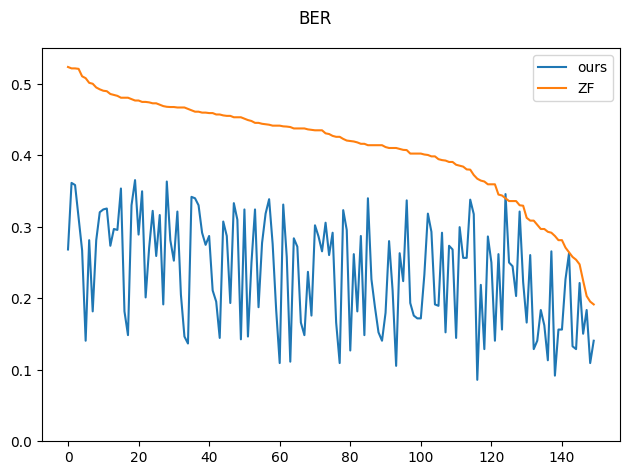

>> time cost: 1.68
>> avg. BER = 0.23717
>> score: 106.57029410287105


In [2]:
from main import ising_generator, qaia_mld_solver

dataset = []
filelist = glob(f'MLD_data/*.pickle')
for filename in filelist:
    with open(filename, 'rb') as fh:
        data = pickle.load(fh)
    dataset.append([data['H'], data['y'], data['bits'], data['num_bits_per_symbol'], data['SNR'], data['ZF_ber']])

judger = Judger(dataset)
t = time()
avgber = judger.benchmark(ising_generator, qaia_mld_solver)
ts = time() - t
print(f'>> time cost: {ts:.2f}')
print(f">> avg. BER = {avgber:.5f}")